<a href="https://colab.research.google.com/github/tschelli/Stroke_Prediction_Project/blob/main/Stroke_Prediction_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Stroke Prediction 

Coding Dojo Data Science Project 2

- Name: Tyler Schelling
- Date Started: 11/2/2022

- Last Updated: 11/17/2022

---

##Dataset Source


Dataset can be found on Kaggle: [Stroke Prediction Dataset]https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset)

##Data Dictionary


Column Name | Description
---|---
id | Unique identifier
gender| 'Male', 'Female', or 'Other'
age| Age of the patient
hypertension | 0 if patient doesn't have hypertension, 1 if the patient has hypertension
ever_married | 'No' or 'Yes'
work_type | 'children', 'govt_job', 'never_worked', 'private', or 'self-employed'
Residence_type | 'Rural' or 'Urban'
avg_glucose_level | average glucose level in blood
bmi | body mass index
smoking_status | 'formerly smoke', 'never smoked', 'smokes', or 'unknown'
stroke | 1 if the patient had a stroke or 0 if not

##Mount Drive | Import Libraries | Download Data

In [260]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [261]:
# Import necessary libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as smote_pipe
from imblearn.over_sampling import SMOTE

import time

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report, roc_auc_score, RocCurveDisplay

from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

from sklearn import set_config
set_config(display='diagram')

In [262]:
#Download the data and display the head of the dataframe
filename = '/content/drive/MyDrive/02. Life/Coding Dojo/00 Datasets/healthcare-dataset-stroke-data.csv'
df = pd.read_csv(filename)
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [263]:
#Evaluate size of the dataframe
print(f'The dataset contains {df.shape[0]} rows and {df.shape[1]} columns.')

The dataset contains 5110 rows and 12 columns.


##Explore and Clean the Dataset

###Copy DF for Exploratory Analysis and Machine Learning

In [264]:
#Create df copies in order to keep original data (df) intact
eda_df = df.copy()
ml_df = df.copy()

---

###Check for Unnecessary Columns

- The `id` column provides no value for predictive modeling. It can be dropped.

In [265]:
#Dropping the id column from both df's
eda_df.drop(columns = 'id', inplace = True)
ml_df.drop(columns = 'id', inplace = True)

- `id` has been dropped from both dataframes as it provides no value in exploratory analysis or machine learning. 

---

###Check for Duplicates

In [266]:
#Evalutate if duplicates are present in the dataframe
eda_df.duplicated().sum()

0

- No duplicated rows

---

###Identify Missing Values

In [267]:
#Iterates through columns with missing values to determine the total quantity and percent missing from the column.
col_with_nan = [features for features in eda_df.columns if eda_df[features].isnull().sum()>=1]
total_nan = []
for col in col_with_nan:
    total_nan.append(eda_df[col].isnull().sum())
percent_nan = []
for col in col_with_nan:
    percent_nan.append(np.round(eda_df[col].isnull().mean(),5))

print(f'The column(s) {col_with_nan} have {total_nan} missing values accounting for {percent_nan} % of the columns missing values respectively. ')

The column(s) ['bmi'] have [201] missing values accounting for [0.03933] % of the columns missing values respectively. 


- The `bmi` column has 201 missing values (0.03933% missing values). 

###Address Missing Values

Missing values will only be addressed for exploratory data analysis (eda_df) at this time. Machine learning missing values will be imputed at a later time to prevent data leakage.

In [268]:
#Fill missing BMI values in with the median value based on the gender for EDA purposes. 
#Machine learning will be imputed at a later time to avoid data leakage.
eda_df['bmi'] = eda_df['bmi'].fillna(eda_df.groupby('gender')['bmi'].transform('median'))

print(eda_df['bmi'].isnull().sum())

0


- All missing values in `eda_df` have been addressed.

---

###Identify Inconsistencies in Categorical Values

In [269]:
#Iterate through categorical columns to print values to determine if inconsistencies are present.
cat_cols = [columns for columns in eda_df.columns if eda_df[columns].dtype=='object']

for col in cat_cols:
    print(f'{col}:')
    print(eda_df[col].value_counts())
    print('\n')

gender:
Female    2994
Male      2115
Other        1
Name: gender, dtype: int64


ever_married:
Yes    3353
No     1757
Name: ever_married, dtype: int64


work_type:
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64


Residence_type:
Urban    2596
Rural    2514
Name: Residence_type, dtype: int64


smoking_status:
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64




- No major inconsistencies present in categorical data
- Only 1 data point for `gender` being 'Other' may be of concern, but will remain untouched.

In [270]:
#Verify the age values in work_type = children are valid.
age_filter = eda_df['work_type'] == 'children'
eda_df[age_filter]['age'].max()

16.0

- Verified the age of `work_type` = `children` is valid.

###EDA Visuals

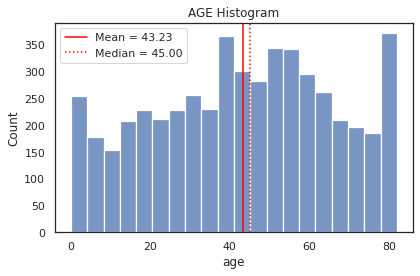

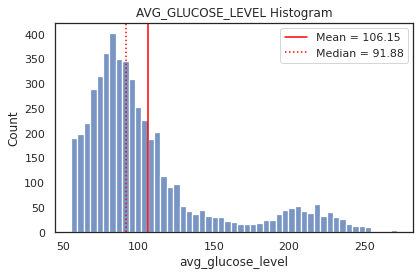

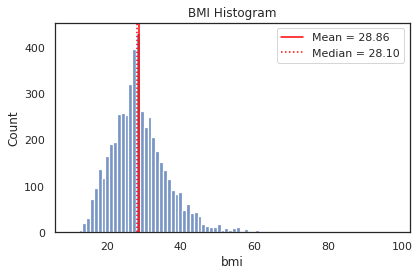

In [271]:
#Histograms for continuous values
continuous_cols = ['age', 'avg_glucose_level', 'bmi']

for cols in continuous_cols:
    mean = eda_df[cols].mean()
    median = eda_df[cols].median()
    fig, ax = plt.subplots(nrows=1, facecolor='w')
    sns.histplot(data = eda_df[cols], linewidth = 1.25, bins = 'auto')
    ax.axvline(mean, color = 'red', linewidth = 1.5, label = f'Mean = {mean:,.2f}')
    ax.axvline(median, color = 'red', ls = 'dotted', linewidth = 1.5, label = f'Median = {median:,.2f}')
    plt.title(f'{cols.upper()} Histogram')
    ax.legend()
    plt.tight_layout()
    plt.show();

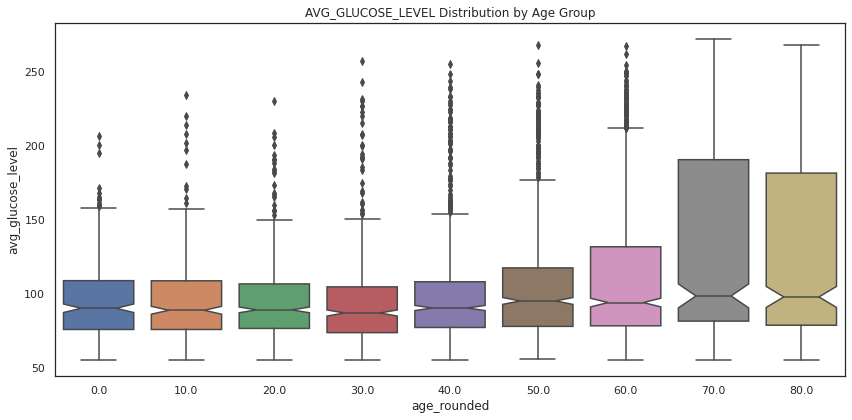

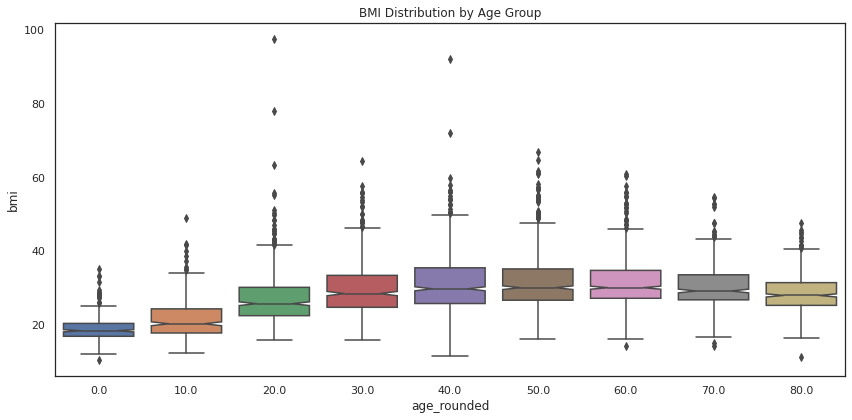

In [272]:
#Create a new column to group the ages rounded to the nearest tenth
eda_df['age_rounded'] = eda_df['age'].round(-1)

#Boxplots to show distribution of data in two continuous columns with potential for outliers.
outlier_cols = ['avg_glucose_level', 'bmi']

for cols in outlier_cols:
    fig, ax = plt.subplots(nrows=1, facecolor='w', figsize = (12,6))
    sns.boxplot(data = eda_df, x=eda_df['age_rounded'], y = eda_df[cols], notch = True)
    plt.title(f'{cols.upper()} Distribution by Age Group')
    plt.tight_layout()
    plt.show();  

###Evaluate Outliers

Outliers in `avg_glucose_level` are high, but are not completely unreasonable. Values will remain untouched.

Outliers in `bmi` that are greater than 70 seem unrealistic and will require further evaluation.

In [273]:
#Create a BMI filter and apply to the df
bmi_filter = eda_df['bmi'] > 70

eda_df[bmi_filter]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_rounded
544,Male,42.0,0,0,Yes,Private,Rural,210.48,71.9,never smoked,0,40.0
928,Female,23.0,1,0,No,Private,Urban,70.03,78.0,smokes,0,20.0
2128,Male,17.0,1,0,No,Private,Rural,61.67,97.6,Unknown,0,20.0
4209,Male,38.0,1,0,Yes,Private,Rural,56.90,92.0,never smoked,0,40.0


- Row 544 will remain due to the high `avg_glucose_level` in conjunction with their high `bmi`.
- The other 3 rows will be dropped. 
    - Greater than 78 `bmi` levels with relatively normal `avg_glucose_level`'s would be incredibly unlikely. 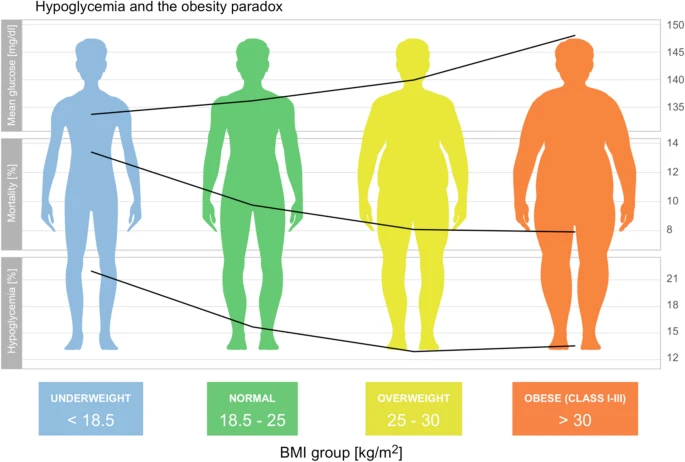
    - Only removing 0.00059% of the data from the dataset.

In [274]:
#Drop the index values of the associated rows that were deemed to have too high of a BMI.
eda_df.drop([928, 2128, 4209], axis= 0, inplace=True)
ml_df.drop([928, 2128, 4209], axis= 0, inplace=True)

#Verify high BMI's were removed.
display(eda_df[bmi_filter])
print('\n')
display(ml_df[ml_df['bmi'] > 70])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_rounded
544,Male,42.0,0,0,Yes,Private,Rural,210.48,71.9,never smoked,0,40.0


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
544,Male,42.0,0,0,Yes,Private,Rural,210.48,71.9,never smoked,0


- Outliers in continuous data dropped

##Exploratory Data Analysis

In [275]:
#Replace 0 and 1 with descriptions for visualizations
str_dict = {0: 'No Stroke', 1: 'Stroke'}
eda_df['stroke'].replace(str_dict, inplace = True)

In [276]:
eda_df['stroke'].value_counts()

No Stroke    4858
Stroke        249
Name: stroke, dtype: int64

###Functions for Plot Creation

In [277]:
def histbox_plot(column_name, x_Label, bin_count):
    sns.set(style="white")
    palette_dict = {'Stroke': 'darkred', 'No Stroke': 'green'}

    fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(10, 6))
    plt.suptitle(f'{column_name.capitalize()} Distribution', y=1.02, va='center', fontsize = 19, weight='bold')

    sns.boxplot(data = eda_df, x = column_name, ax=ax_box, color = '#3b6f82')
    ax_box.spines['top'].set_color(None)
    ax_box.spines['bottom'].set_color(None)
    ax_box.spines['left'].set_color(None)
    ax_box.spines['right'].set_color(None)

    sns.histplot(data = eda_df, x = column_name, ax=ax_hist, color = '#14e01b', bins = bin_count, edgecolor="black", hue="stroke",palette=palette_dict,hue_order=['Stroke','No Stroke'])
    plt.xlabel(x_Label, fontsize = 16, weight='bold')
    plt.xticks(weight='bold')
    ax_hist.set_ylabel('Count',fontweight='bold',fontsize=18)
    ax_hist.tick_params(labelcolor='k', labelsize=10)
    ax_hist.set_yticklabels(ax_hist.get_yticks(), weight='bold')
    
    ax_box.set(xlabel='') 
    plt.tight_layout();
    plt.show();

In [278]:
def scatter_plot(x, y):
    palette_dict = {'Stroke': 'darkred', 'No Stroke': 'green'}
    fig, ax = plt.subplots(figsize=(8,6), facecolor='w')
    sns.scatterplot(hue_order=['Stroke','No Stroke'], data=eda_df.sort_values('stroke'), x=x, y=y, hue="stroke", palette=palette_dict);
    plt.title(f'{x.capitalize()} and {y.capitalize()} \ncorrelation to Stroke Outcome', fontsize = 18, weight='bold')
    plt.xlabel(f'{x}', fontsize = 14, weight='bold')
    plt.ylabel(f'{y}', fontsize = 14, weight='bold');
    plt.xticks(fontsize = 10, weight='bold')
    plt.yticks(fontsize = 10, weight='bold');
    plt.legend(bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show;

In [279]:
def hist_density_plot(x):
    sns.set(style="white")
    palette_dict = {'Stroke': 'darkred', 'No Stroke': 'green'}
    fig, ax = plt.subplots(figsize=(8,6), facecolor='w')
    sns.histplot(data=eda_df.sort_values('stroke'), x = x, hue='stroke', multiple="dodge", stat = 'percent', shrink = 0.8, common_norm=True, palette=palette_dict)
    plt.title(f'Normalized Distribution for {x.capitalize()} based on stroke outcome', fontsize = 18, weight='bold')
    plt.xlabel(f'{x}', fontsize = 14, weight='bold')
    plt.xticks(fontsize = 10, weight='bold')
    plt.yticks(fontsize = 10, weight='bold');
    plt.tight_layout()
    plt.show;

###Correlation to Target

In [280]:
#Create a features dataframe to encode categorical data for correlation
feat_df = eda_df.copy()
feat_df.drop(columns = 'age_rounded', inplace = True)
objList = feat_df.select_dtypes(include = "object").columns
feat_df[objList] = feat_df[objList].apply(LabelEncoder().fit_transform)

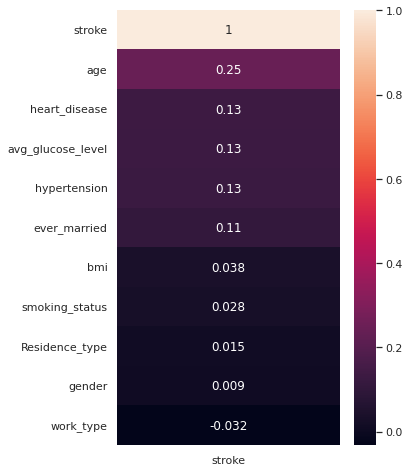

In [281]:
#Sort the correlations of each column to SalePrice
corr = feat_df.corr()[['stroke']].sort_values(by = 'stroke', ascending = False)
plt.figure(figsize= (5,8))
sns.heatmap(corr, annot = True);

- No features particularly stick out for correlation to the target variable. 
- Age, heart_disease, avg_glucose_level, and hypertension have the largest correlation to a patient having a stroke.
- Ever_married strangely has a similar degree of correlation as the medical related columns. 

###Univariate Analysis

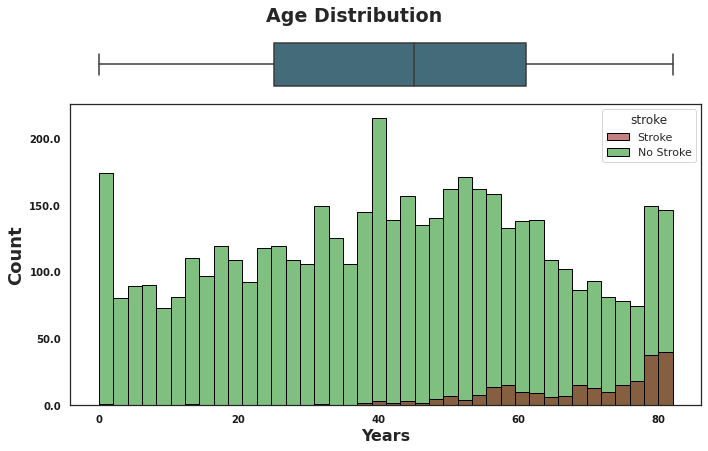

In [282]:
histbox_plot('age', 'Years', 40)

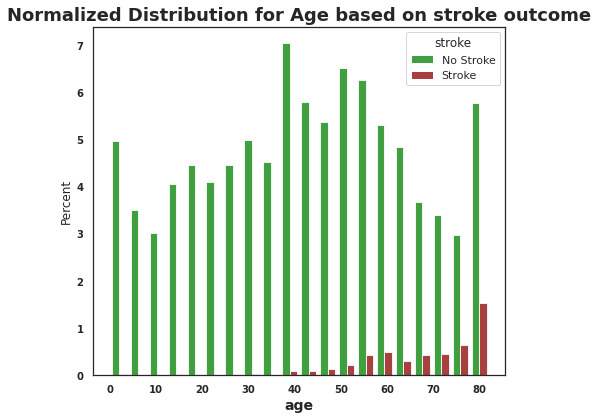

In [283]:
hist_density_plot('age')

- There is a good distribution of ages.
- Age is the primary factor in predicting whether or not a patient will have a stroke.
    - The distribution for age is left-skewed for patients that have had a stroke.

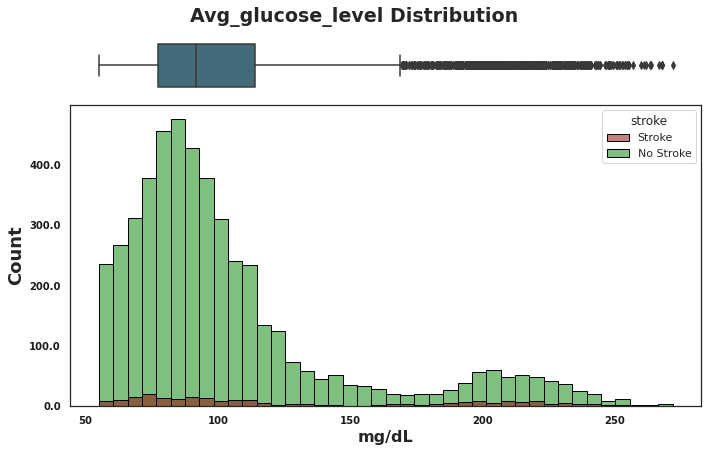

In [284]:
histbox_plot('avg_glucose_level', 'mg/dL', 40)

- Distribution for average glucose levels appear normal. Majority of data lies under 150 mg/dL which is reasonable for most individuals. 
- Outliers beyond 150 are present and appear to have a minor impact in predicting if a patient will have a stroke or not.

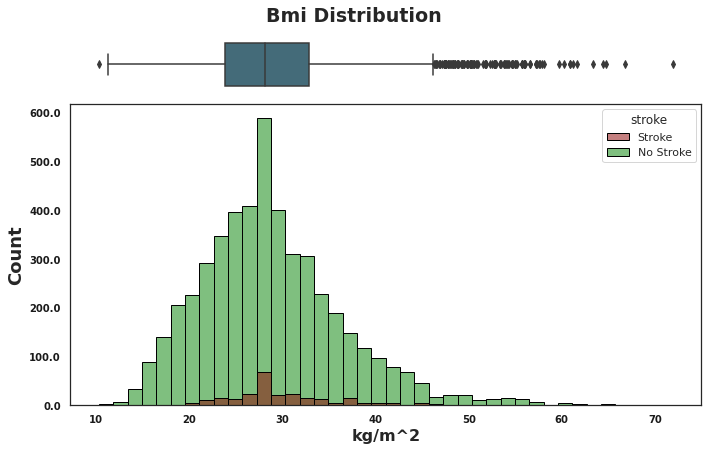

In [285]:
histbox_plot('bmi', 'kg/m^2', 40)

- BMI has a normal distribution of data with a slight right-skew due to outliers. 
- Most patients in this dataset would be considered overweight and obese for having a BMI greater than 25. 
- BMI surprisingly has little to no impact on predicting if a patient will have a stroke. 

###Multivariate Analysis

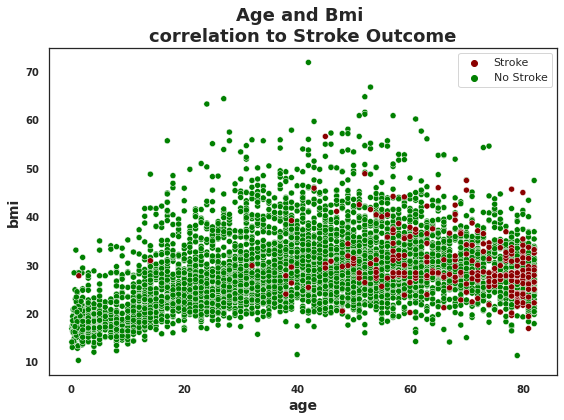

In [286]:
scatter_plot('age', 'bmi')

- BMI has a slight upward trend as a patient gets older, however it doesn't appear to have as much of an impact on stroke prediction as age. 

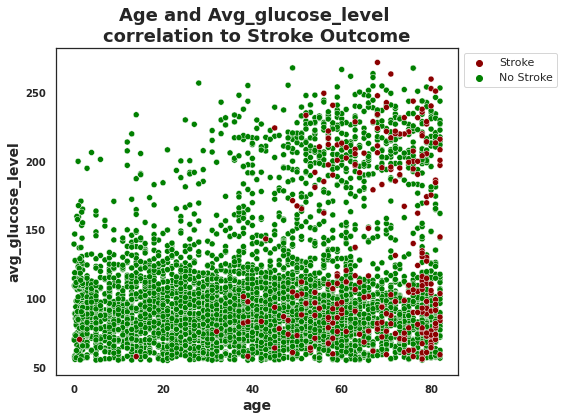

In [287]:
scatter_plot('age', 'avg_glucose_level')

- Older patients have a clear trend of having higher `avg_glucose_levels`, however glucose levels do not appear to have a significant impact on stroke prediction.

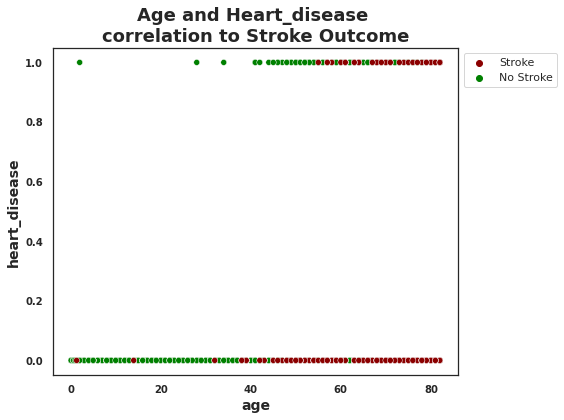

In [288]:
scatter_plot('age', 'heart_disease')

- Again, a clear separation based on age for predicting strokes, but there is no significant impact heart_disease has on stroke outcomes.

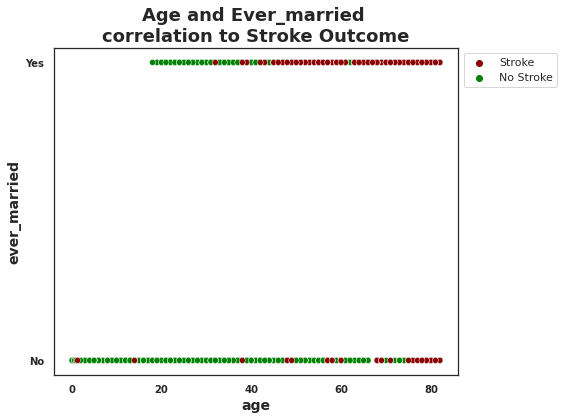

In [289]:
scatter_plot('age', 'ever_married')

- Surprisingly, patients that were married have a correlation to stroke outcome. 
- A possible explanation could be that older patients are more likely to be married in their life and may not actually relate to the health of the patient. 


##Data Preprocessing

Start with copying ml_df. We will use the copy later for feature engineering.

In [290]:
ml2_df = ml_df.copy()

In [291]:
ml_df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


- **Nominal Features:** Gender, Hypertension, Heart_disease, Ever_married, Work_type, Residence_type, Smoking_status, Stroke
- **Numeric Features:** Age, Avg_Glucose_level, BMI

In [292]:
ml_df['stroke'].value_counts(normalize = True)

0    0.951243
1    0.048757
Name: stroke, dtype: float64

- Dataset target is not balanced. SMOTE will be used to balance the dataset.

###Validation Split

In [293]:
X = ml_df.drop(columns = ['stroke'])
y = ml_df['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

###Column Selectors

In [294]:
ml_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5107 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5107 non-null   object 
 1   age                5107 non-null   float64
 2   hypertension       5107 non-null   int64  
 3   heart_disease      5107 non-null   int64  
 4   ever_married       5107 non-null   object 
 5   work_type          5107 non-null   object 
 6   Residence_type     5107 non-null   object 
 7   avg_glucose_level  5107 non-null   float64
 8   bmi                4906 non-null   float64
 9   smoking_status     5107 non-null   object 
 10  stroke             5107 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 478.8+ KB


Will change all Nominal features listed above to 'object' datatype in order to OneHotEncode.

In [295]:
#Change the int64 nominal columns to objects
ml_df['hypertension'] = ml_df['hypertension'].astype(str)
ml_df['heart_disease'] = ml_df['heart_disease'].astype(str)
ml_df['stroke'] = ml_df['stroke'].astype(str)

In [296]:
#Create column selectors
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')

###Instantiate Transformers

In [297]:
median_imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown = 'ignore', sparse = False)

###Create Pipelines/ColumnTransformer

In [298]:
#Create the numeric pipeline
num_pipe = make_pipeline(median_imputer, scaler)
num_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [299]:
num_tup = (num_pipe, num_selector)
cat_tup = (ohe, cat_selector)

preprocessor = make_column_transformer(num_tup, cat_tup, remainder = 'passthrough')

preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fc6cccdd210>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fc6cccdd310>)])

###Review the Preprocessed Results

In [300]:
# Fit on Train
preprocessor.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fc6cccdd210>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fc6cccdd310>)])

In [301]:
# Transform Train and Test
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [302]:
# Check for missing values and that data is scaled and one-hot encoded
print(f'{np.isnan(X_train_processed).sum()} missing values in the training data and {np.isnan(X_test_processed).sum()} missing values in the test data.')
print(f'All data in X_train_processed are {X_train_processed.dtype} and X_test are {X_test_processed.dtype}.')
print(f'There are {X_train_processed.shape[0]} rows and {X_train_processed.shape[1]} columns in the train dataset.')

0 missing values in the training data and 0 missing values in the test data.
All data in X_train_processed are float64 and X_test are float64.
There are 3830 rows and 20 columns in the train dataset.


###Instantiate SMOTE

In [303]:
#Create an instance of smote to be used later on for oversampling during model fitting
smote = SMOTE(random_state = 42)

##Model Evaluation

In [304]:
models = [['Decision Tree', DecisionTreeClassifier(random_state=42)], 
          ['Random Forest', RandomForestClassifier(random_state=42)],
          ['Logistic Regression', LogisticRegression(random_state=42)],
          ['KNeighbors', KNeighborsClassifier()],
          ['ADA Boost', AdaBoostClassifier(random_state = 42)],
          ['Light GBM', LGBMClassifier(random_state = 42)],
          ['XGBoost', XGBClassifier(random_state = 42)],
          ['Gradient Boosting', GradientBoostingClassifier(random_state = 42)]]

In [305]:
baseline_model_scores = pd.DataFrame(columns = ['Model', 'Accuracy Score', 'Precision Score', 'Recall Score', 'F1 Score', 'ROC', 'Execution Time'])

for model in range(len(models)):
    stats = []
    tic = time.time()
    current_model = models[model][1]
    smote_model = smote_pipe(preprocessor, smote, current_model)
    smote_model.fit(X_train, y_train)
    y_pred = smote_model.predict(X_test)
    #cm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)
    toc = time.time()
    time_taken = round(toc - tic, 2)
    stats.extend([models[model][0], accuracy, precision, recall, f1, roc, time_taken])
    baseline_model_scores.loc[len(baseline_model_scores.index)] = stats

    print(models[model][0], ':\n')
    print(classification_report(y_test, y_pred))
    #print(cm)
    print('---------------------------\n')


Decision Tree :

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      1197
           1       0.13      0.19      0.16        80

    accuracy                           0.87      1277
   macro avg       0.54      0.55      0.54      1277
weighted avg       0.89      0.87      0.88      1277

---------------------------

Random Forest :

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1197
           1       0.12      0.05      0.07        80

    accuracy                           0.92      1277
   macro avg       0.53      0.51      0.51      1277
weighted avg       0.89      0.92      0.90      1277

---------------------------

Logistic Regression :

              precision    recall  f1-score   support

           0       0.98      0.75      0.85      1197
           1       0.16      0.71      0.26        80

    accuracy                           0.75      1277
   macro avg 

In [306]:
baseline_model_scores

,Model,Accuracy Score,Precision Score,Recall Score,F1 Score,ROC,Execution Time
0,Decision Tree,0.872357,0.132743,0.1875,0.155440,0.552814,0.17
1,Random Forest,0.918559,0.125000,0.0500,0.071429,0.513304,1.34
2,Logistic Regression,0.751762,0.162393,0.7125,0.264501,0.733443,0.43
3,KNeighbors,0.815975,0.142857,0.3875,0.208754,0.616056,0.47
4,ADA Boost,0.849648,0.181818,0.4000,0.250000,0.639850,0.80
5,Light GBM,0.913078,0.102564,0.0500,0.067227,0.510380,0.69
6,XGBoost,0.871574,0.166667,0.2625,0.203883,0.587390,0.69
7,Gradient Boosting,0.882537,0.198276,0.2875,0.234694,0.604903,1.51


- Random Forest and Light GBM had the highest accuracy and precision across all of the models.
- However, Recall will be the metric we would like to maximize when predicting stroke outcomes and the Logistic Regression model maximized the recall (0.713).
    - Logistic Regression also had the lowest accuracy.
- ADA Boost was the next highest recall across the models at 0.40.

Tuning the models will be performed next to see if better results can be achieved. 

##Model Tuning

In [307]:
model_params = [['Decision Tree Tuned', DecisionTreeClassifier(), [{'decisiontreeclassifier__max_depth': list(range(1, 16, 2)), 'decisiontreeclassifier__random_state': [42], 
                                                                    'decisiontreeclassifier__criterion': ['gini', 'entropy']}]],
                ['Random Forest Tuned', RandomForestClassifier(), [{'randomforestclassifier__max_depth': list(range(1, 16, 2)), 
                                                                    'randomforestclassifier__n_estimators': list(range(100, 201, 50)), 'randomforestclassifier__random_state': [42],
                                                                    'randomforestclassifier__criterion': ['gini', 'entropy']}]],
                ['Logistic Regression Tuned', LogisticRegression(), [{'logisticregression__C': [.01, .5, 1, 10, 100], 'logisticregression__penalty': ['l1', 'l2', 'none'], 
                                                                      'logisticregression__random_state': [42]}]],
                ['KNeighbors Tuned', KNeighborsClassifier(),[{'kneighborsclassifier__n_neighbors': list(range(3, 9)), 
                                                              'kneighborsclassifier__metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']}]], 
                ['ADA Boost Tuned', AdaBoostClassifier(), [{'adaboostclassifier__n_estimators': list(range(100, 201, 50)), 'adaboostclassifier__random_state': [42]}]], 
                ['Light GBM Tuned', LGBMClassifier(), [{'lgbmclassifier__max_depth': list(range(1, 16, 2)),'lgbmclassifier__random_state': [42]}]], 
                ['XGBoost Tuned', XGBClassifier(), [{'xgbclassifier__max_depth': list(range(1, 16, 2)), 'xgbclassifier__n_estimators': list(range(100, 201, 50)), 'xgbclassifier__random_state': [42]}]],
                ['Gradient Boosting Tuned', GradientBoostingClassifier(), [{'gradientboostingclassifier__max_depth': list(range(1, 16, 2)),'random_state': [42], 
                                                                            'gradientboostingclassifier__n_estimators': list(range(100, 201, 50)), 'gradientboostingclassifier__random_state': [42]}]]]

In [ ]:
tuned_model_scores = pd.DataFrame(columns = ['Model', 'Accuracy Score', 'Precision Score', 'Recall Score', 'F1 Score', 'ROC', 'Best Parameters', 'Execution Time'])

for model_name, model, params in model_params:
    stats = []
    tic = time.time()
    smote_model = smote_pipe(preprocessor, smote, model)
    grid = GridSearchCV(estimator = smote_model, param_grid = params, scoring = 'recall', cv = 10)
    grid.fit(X_train, y_train)
    best_param = grid.best_params_
    best_model = grid.best_estimator_
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    #cm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)
    toc = time.time()
    time_taken = round(toc - tic, 2)
    stats.extend([model_name, accuracy, precision, recall, f1, roc, best_param, time_taken])
    tuned_model_scores.loc[len(tuned_model_scores.index)] = stats

    print(model_name, ':\n')
    print(classification_report(y_test, y_pred))
    #print(cm)
    print('---------------------------\n')

##Dimensionality Reduction

###PCA

In [251]:
tuned_model_scores[['Model', 'Best Parameters']]

,Model,Best Parameters
0,Decision Tree Tuned,{'decisiontreeclassifier__criterion': 'entropy...


In [252]:
pca = PCA(n_components = .95)

pca_pipe = make_pipeline(preprocessor, pca)

In [ ]:
tuned_models = [['Decision Tree Tuned PCA', DecisionTreeClassifier(random_state=42)], 
                ['Random Forest Tuned PCA', RandomForestClassifier(random_state=42)],
                ['Logistic Regression Tuned PCA', LogisticRegression(random_state=42)],
                ['KNeighbors Tuned PCA', KNeighborsClassifier()],
                ['ADA Boost Tuned PCA', AdaBoostClassifier(random_state = 42)],
                ['Light GBM Tuned PCA', LGBMClassifier(random_state = 42)],
                ['XGBoost Tuned PCA', XGBClassifier(random_state = 42)],
                ['Gradient Boosting Tuned PCA', GradientBoostingClassifier(random_state = 42)]]

                #Add best parameters into models

In [ ]:
pca_model_scores = pd.DataFrame(columns = ['Model', 'Accuracy Score', 'Precision Score', 'Recall Score', 'F1 Score', 'ROC', 'Execution Time'])

for model in range(len(tuned_models)):
    stats = []
    tic = time.time()
    current_model = tuned_models[model][1]
    smote_model = smote_pipe(pca_pipe, smote, current_model)
    smote_model.fit(X_train, y_train)
    y_pred = smote_model.predict(X_test)
    cm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)
    toc = time.time()
    time_taken = round(toc - tic, 2)
    stats.extend([tuned_models[model][0], accuracy, precision, recall, f1, roc, time_taken])
    pca_model_scores.loc[len(pca_model_scores.index)] = stats

    print(tuned_models[model][0], ':\n')
    print(classification_report(y_test, y_pred))
    print(cm)
    print('---------------------------\n')


##Feature Engineering

In [253]:
ml2_df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [256]:
ml2_df = ml2_df.replace({'hypertension': {0:1, 1:2}, 'heart_disease': {0:1, 1:2}, 'smoking_status': {'formerly smoked': 1.5, 'smokes': 2, 'never smoked': 1, 'Unknown': 1}})
ml2_df['unhealthy'] = (ml2_df['age'] * ml2_df['bmi'] * ml2_df['avg_glucose_level'] * ml2_df['hypertension'] * ml2_df['heart_disease'] * ml2_df['smoking_status']) / 10000
ml2_df.drop(columns = ['age', 'avg_glucose_level', 'bmi','hypertension', 'heart_disease', 'smoking_status'], inplace = True)
ml2_df.head()

,gender,ever_married,work_type,Residence_type,stroke,unhealthy
0,Male,Yes,Private,Urban,1,336.476171
1,Female,Yes,Self-employed,Rural,1,NaN
2,Male,Yes,Private,Rural,1,110.156800
3,Female,Yes,Private,Urban,1,230.900230
4,Female,Yes,Self-employed,Rural,1,132.052608
